In [1]:
import torch
from torch import nn
from torch.nn import functional as F

import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
X = torch.tensor([
    [1, 0],
    [0, 1],
    [0, 1],
    [1, 0],
    [0, 1],
], dtype=torch.float32, device=device)

Y = torch.tensor([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1],
    [0, 0, 1],
    [1, 0, 0],
], dtype=torch.float32, device=device)

In [4]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(RNN, self).__init__()
        
        self.weather_layer = nn.Linear(input_size, output_size, bias=False)
        self.food_layer = nn.Linear(output_size, output_size, bias=False)
    
    def forward(self, weather, food):
        o1 = self.weather_layer(weather)
        o2 = self.food_layer(food)
        out = o1 + o2
        return out

In [5]:
class RNNWeather(nn.Module):
    def __init__(self, input_size, output_size):
        super(RNNWeather, self).__init__()
        
        self.weather_layer = nn.Linear(input_size, input_size * output_size, bias=False)
        self.food_layer = nn.Linear(output_size, input_size * output_size, bias=False)
        self.output_layer = nn.Linear(input_size * output_size, output_size, bias=False)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, weather, food):
        o1 = self.weather_layer(weather)
        o2 = self.food_layer(food)
        out = self.output_layer(o1 + o2)
        
        o_add = o1 + o2
        
        o_nonlinear = self.softmax(o_add)
        print("o_nonlinear", o_nonlinear)
        
        out = torch.zeros_like(food)
        for i in range(len(o_nonlinear)):
            o_halves = torch.split(o_nonlinear[i], int(len(o_nonlinear[i])/2), dim=0)
            o_merge = torch.vstack(o_halves).T
            o_merge = torch.sum(o_merge, axis=1)
            out[i] = o_merge
        print("out", out)
        return out

In [6]:
# rnn = RNN(input_size=2, output_size=3).to(device)
rnn = RNNWeather(input_size=2, output_size=3).to(device)

In [7]:
def get_input(x):
    inputs = ("sunny", "rainy")
    return inputs[torch.argmax(x)]

def get_class(o):
    classes = ("pie", "burger", "chicken")
    if torch.max(o) == 0:
        return "nothing"
    return classes[torch.argmax(o)]

In [8]:
optimizer = torch.optim.SGD(rnn.parameters(), 1e-1)

In [9]:
criterion = nn.MSELoss()
# criterion = nn.CrossEntropyLoss()

In [10]:
print(list(rnn.parameters()))

[Parameter containing:
tensor([[-0.6362,  0.3201],
        [ 0.0245, -0.4660],
        [-0.0737,  0.3650],
        [ 0.2662, -0.6368],
        [-0.4752, -0.1780],
        [-0.2563,  0.5413]], requires_grad=True), Parameter containing:
tensor([[ 0.5703,  0.5605, -0.5635],
        [ 0.5279, -0.3239, -0.1022],
        [-0.2333, -0.2059, -0.0671],
        [ 0.1173, -0.0450, -0.4973],
        [ 0.1707, -0.3254,  0.3052],
        [-0.5497,  0.2018, -0.4052]], requires_grad=True), Parameter containing:
tensor([[-0.2305, -0.3121,  0.2749,  0.0065, -0.3692,  0.2027],
        [ 0.2253, -0.3704, -0.3102,  0.0656,  0.3492,  0.2229],
        [ 0.4026, -0.0883, -0.0716, -0.0868,  0.1539, -0.1817]],
       requires_grad=True)]


In [ ]:
O = torch.full_like(Y, float('nan'))
losses = []
for epoch in range(30):
    for i in range(len(X)):
        rnn.train()
        x = X[i:i+1]
        y = Y[i:i+1]

        if i - 1 < 0:
            y_prev = torch.zeros_like(y, dtype=torch.float32)
        else:
            y_prev = o.clone().detach()

        optimizer.zero_grad()

        O[i] = o = rnn(x, y_prev)
#         if epoch == 4:
        print(get_input(x), "+", get_class(y_prev), '=', get_class(o), '|', get_class(y))

        loss = criterion(o, y)
#         a = y.argmax(dim=1)
#         loss = criterion(o, a)
        loss.backward()
        optimizer.step()
        losses.append(loss.clone().detach())
print(list(rnn.parameters()))
print("-" * 30)

In [42]:
print(list(rnn.parameters()))

[Parameter containing:
tensor([[-0.7054,  0.5298],
        [-1.0367, -0.1245],
        [ 0.6188, -0.2819],
        [ 1.4679, -0.5685],
        [-1.2669,  0.1487],
        [-0.2284,  0.2421]], requires_grad=True), Parameter containing:
tensor([[ 0.2199,  0.0423, -0.3955],
        [ 0.7854, -0.6175, -0.2904],
        [ 0.1242,  0.9339,  0.7259],
        [-0.6051, -0.7770, -1.3775],
        [ 0.5946, -0.6703,  0.1120],
        [-0.5158,  0.9508, -0.1046]], requires_grad=True), Parameter containing:
tensor([[-0.2305, -0.3121,  0.2749,  0.0065, -0.3692,  0.2027],
        [ 0.2253, -0.3704, -0.3102,  0.0656,  0.3492,  0.2229],
        [ 0.4026, -0.0883, -0.0716, -0.0868,  0.1539, -0.1817]],
       requires_grad=True)]


No handles with labels found to put in legend.


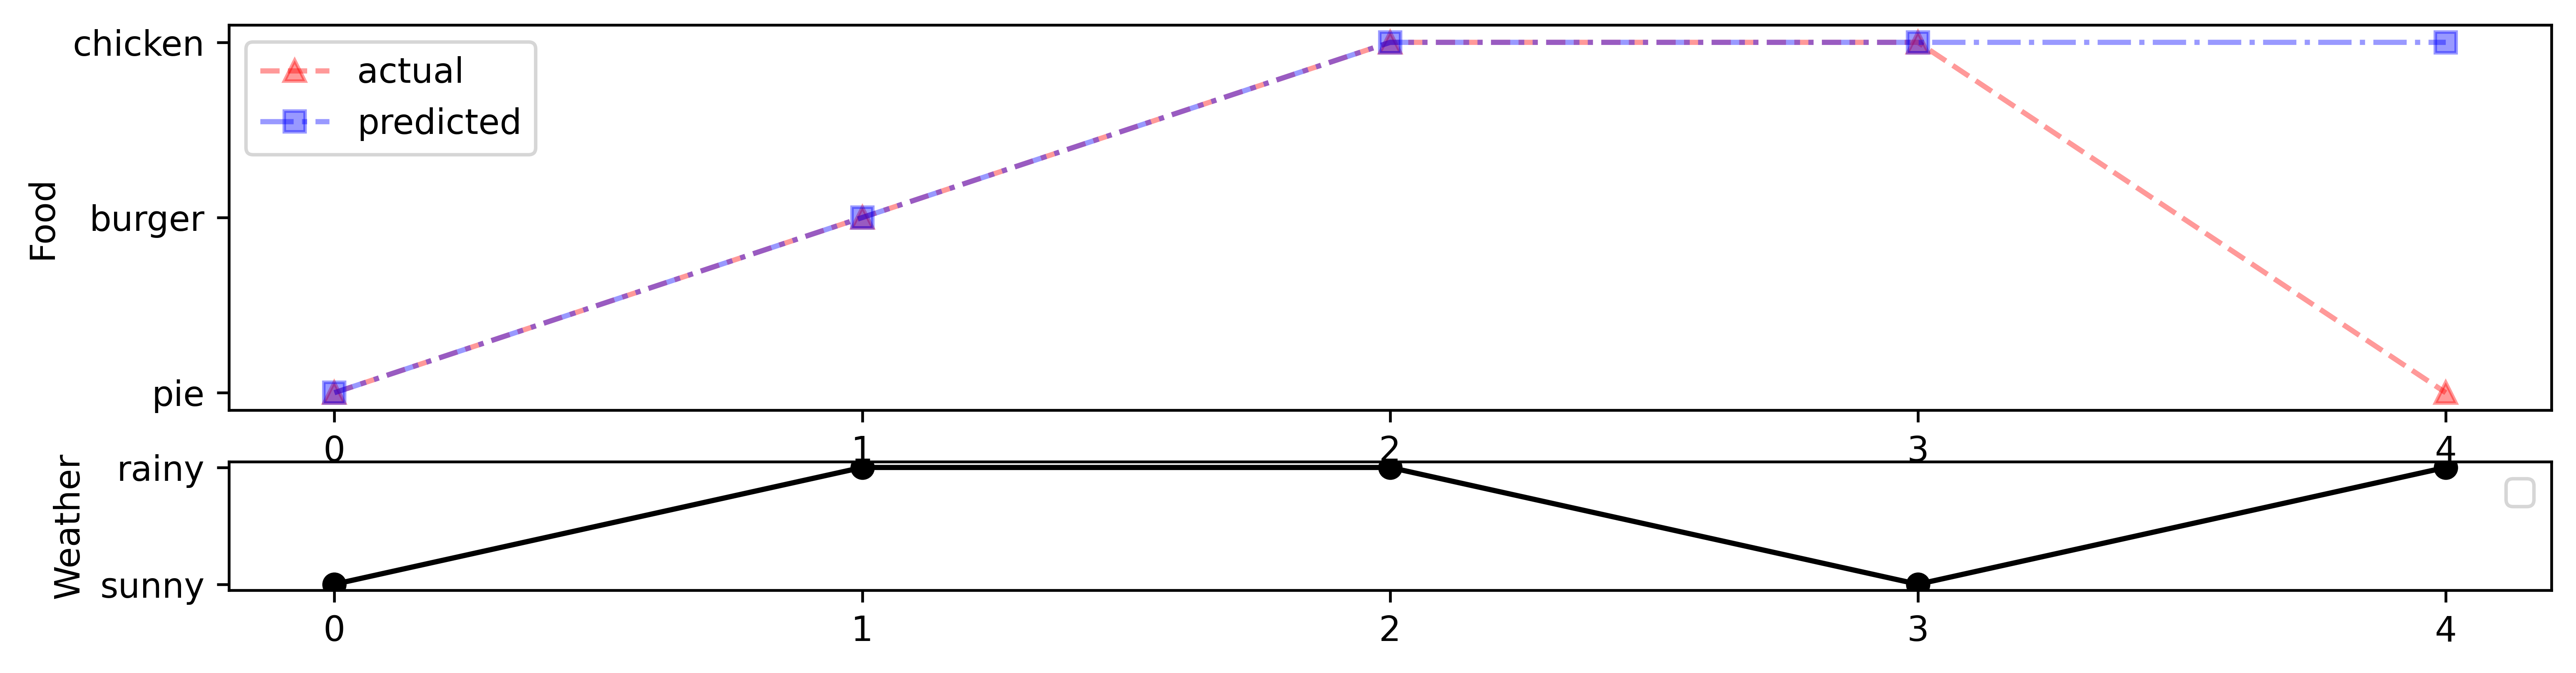

In [43]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
fig, ax = plt.subplots(figsize=(12, 3), nrows=2, dpi=600, gridspec_kw={ 'height_ratios': [3, 1]})

ax[0].plot(torch.argmax(Y, axis=1), '--^', color='red', label="actual", alpha=0.4)
ax[0].plot(torch.argmax(O, axis=1), '-.s', color='blue', label="predicted", alpha=0.4)
ax[0].set_xticks(torch.arange(len(O)))
ax[0].set_ylabel('Food')
foods = ['pie', 'burger', 'chicken']
food_values = torch.arange(len(foods))
ax[0].set_yticks(food_values)
ax[0].set_yticklabels(foods)
ax[0].legend()
# ax[0].add_artist(
#     AnnotationBbox(
#         OffsetImage(food_images[0]),
#         (1, 1),
#         frameon=False,
#     ) 
# )

ax[1].plot(torch.argmax(X, axis=1), '-o', color='black')
ax[1].set_xticks(torch.arange(len(X)))
ax[1].set_ylabel('Weather')
weathers = ['sunny', 'rainy']
weather_values = torch.arange(len(weathers))
ax[1].set_yticks(weather_values)
ax[1].set_yticklabels(weathers)
ax[1].legend()
plt.show()

In [84]:
a = 0.1*torch.normal(0, 1, size=(10, 1))
a.shape

torch.Size([10, 1])

In [105]:
def create_regression_dataset(num):
    X = torch.linspace(-10, 10, steps=num)
    a = 0.1*X*torch.cos(X) + 0.1 * torch.normal(0, 1, size=X.shape)
    Y = 0.1*X*torch.cos(X) + 0.1*torch.normal(0, 1, size=X.shape)
    return X[:, None], Y[:, None]

In [106]:
X_train, Y_train = create_regression_dataset(num=900)
X_test, Y_test = create_regression_dataset(num=100)
N = X_train.shape[0]
C = 1
D = len(X_train[0])

In [107]:
X_train.shape, Y_train.shape

(torch.Size([900, 1]), torch.Size([900, 1]))

In [108]:
def plot_regression(X, Y):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    sample_color = "tab:cyan"
    cmap = 'cool'
    markers = ['o', 's']
    import matplotlib.colors as mcolors
    names = list(mcolors.TABLEAU_COLORS) + list(mcolors.BASE_COLORS) + ["deepskyblue", "crimson", "darkviolet", "orangered"]

    ax.scatter(X, Y, c=sample_color, marker='o', linewidth=1, edgecolor="black", label="$x$")
    
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    
#     ax.set_aspect(1)

#     ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=9)
    
    plt.tight_layout()
    return fig

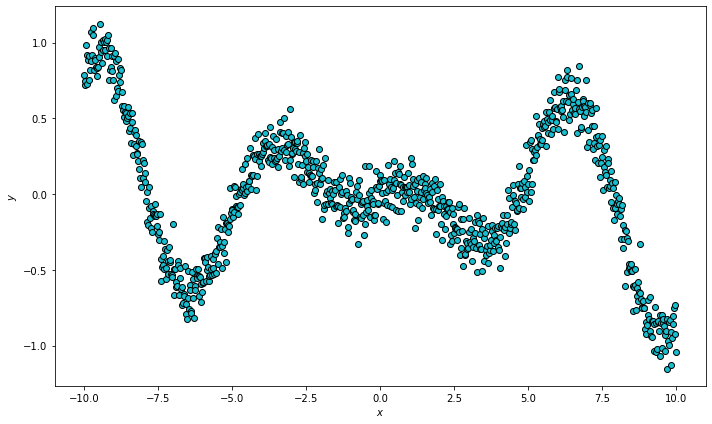

In [109]:
fig = plot_regression(X_train, Y_train)
# fig.savefig("regression-20_training_prototypes.png", dpi=600)

In [117]:
class RNNRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNNRegressor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        
    def forward(self, x):
        h = torch.zeros(self.num_layers, len(x), self.hidden_size)
        y, h = self.rnn(x)
        return y, h

In [120]:
rnn_regressor = RNNRegressor(input_size=X_train.shape[1], hidden_size=10, num_layers=1)

In [130]:
# X = X_train
# Y = Y_train
O = torch.full_like(Y, float('nan'))
losses = []

for epoch in range(1):
    for i in range(len(X)):
        x = X[i:i+1]
        y = Y[i:i+1]

        rnn_regressor.train()
        optimizer.zero_grad()
        o, h = rnn_regressor(x)
        
        loss = criterion(o, y)
        optimizer.step()
        losses.append(loss.detach())
print("-" * 30)

------------------------------


C:\Users\Tommie\miniconda3\envs\stroke\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1, 1, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


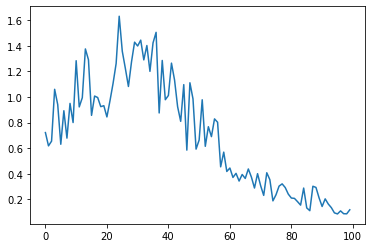

In [131]:
fig, ax = plt.subplots()
ax.plot(losses)

In [126]:
y = np.sin(np.linspace(0,100,1000)+2*np.pi*np.random.rand())
X = torch.autograd.Variable(torch.Tensor(y))[:100].view(-1,1,1)

In [127]:
X.shape, y.shape

(torch.Size([100, 1, 1]), (1000,))